# Intro to MACE

This tutorial is a modified version originally written by Ilyes Batatia.

In this tutorial, you will learn how to fit a Message Passing Neural Network called `MACE`, which is a highly accurate and efficient MLIP. If you would like to understand this method in more detail, you can find the [original method paper](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Paper-Conference.pdf). MACE was developed by unifying the Atomic Cluster Expansion (ACE) approach with the Neural Equivariant Interatomic Potentials (NequIP). The mathematical formalism which unifies these methods is explained in the [accompaning paper](https://doi.org/10.48550/arXiv.2205.06643). Another [useful reference](https://doi.org/10.48550/arXiv.2305.14247) showcases the methods performance on published benchmark datasets. The [code implementation](https://github.com/ACEsuit/mace) is publically available and [here](https://mace-docs.readthedocs.io/en/latest/) you can find the accompaning documentation.

We will start by using a foundational potential which has been recently published and apply it to a system which is outside the scope of it's training. We will then go beyond testing on fixed data and explore the stability of the potential in Molecular Dynamics (MD) simulations. We will then fine-tune the model on relevant data and observe how it changes.

In [ ]:
%%bash
# Install GAP
pip install quippy-ase

# Install MACE
if test -d mace
then
    rm -rfv mace
fi
git clone --depth 1 --branch develop https://github.com/ACEsuit/mace.git 
pip install mace/

# Install extension to ASE
if test -d aseMolec
then
    rm -rfv aseMolec
fi
git clone --depth 1 https://github.com/imagdau/aseMolec.git
pip install aseMolec/

# Using a foundational MACE Model

We will start by using the recently published foundational MACE model out of the box and apply it to graphene oxide (GO) – a 2D oxidised analogue of graphene. The foundational model has not seen this type of data and thus is extrapolating.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from ase import units
from ase.md.npt import NPT
from ase.io import read, write
from ase.md import MDLogger
import numpy as np
import time
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from mace.calculators import mace_mp

calculator = mace_mp()

Using Materials Project MACE for MACECalculator with /u/vld/sedm6197/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [1]:
atoms = read("GO-small.xyz")

atoms.set_calculator(calculator)

dt = 0.5 * units.fs  # fs time step

start = time.time()
# Set the momenta corresponding to T_init (K)
MaxwellBoltzmannDistribution(atoms, temperature_K=1500)

def write_frame():
    dyn.atoms.write("mace_md.xyz", append=True)

print("Initialising structure...")

## Step 1: Liquid equilibration
dyn = NPT(atoms, dt, ttime=10.0 * units.fs, externalstress=0.0, temperature_K=1500)
dyn.attach(write_frame, interval=100)
dyn.attach(
    MDLogger(dyn, atoms, "md.log", stress=False, peratom=True, mode="a"), interval=100
)
dyn.run(20000)

end = time.time()
print("Liquid equilibriation finished!")
print("Time Taken is:")
print(end - start)

Using Materials Project MACE for MACECalculator with model='/u/vld/sedm6197/.cache/mace/y7uhwpje'


/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/tmp/ipykernel_2637870/1879060993.py:19: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calculator)


Default dtype float32 does not match model dtype float64, converting models to float32.
Initialising structure...
Liquid equilibriation finished!
Time Taken is:
246.89920258522034


#### Training files

To train a MACE model, you will use the `run_train.py`command which takes the following arguments:

First specify the name of your model and final log file using the `--name` flag.

You can specify the training file with the `--train_file` flag. The validation set can either be specified as a separate file using the `--valid_file` keyword, or it can be specified as a fraction of the training set using the `--valid_fraction` keyword. The validation set is not used for optimizing the model but to estimate the model accuracy during training.

It is also possible to provide a test set using the `--test_file` keyword. This set is entirely independent and only gets evaluated at the end of the training process.

__________________

#### Reference energies

It is usually preferred to add the isolated atoms to the training set, rather than reading in their energies through the command line. MACE will automatically identify these atoms in the training set if they are labels correctly with `config_type=IsolatedAtom` in their `info` fields (we have done this yesterday when preparing the data). If you prefer not to use or do not know the energies of the isolated atoms, you can use the option `--E0s="average"` which estimates the atomic energies by least squares regression.

__________________


#### Model

##### The Messages

To control the model size, you need to change `--hidden_irreps`. For most applications, the recommended default model size is `--hidden_irreps='256x0e'` (meaning 256 invariant messages) or `--hidden_irreps='128x0e + 128x1o'` (meaning 128 equivariant messages). If the model is not accurate enough, you can include higher order features, e.g., `128x0e + 128x1o + 128x2e`, or increase the number of channels to `256`. The number of message passing layers can be controled via the `--num_ineractions` parameter. **Increasing the model size and the number of layers will lead to more accurate but slower models.**

##### Correlation order

MACE uses a body order expansion on the site energy:

$$
E_{i} = E^{(0)}_{i} + \sum_{j} E_{ij}^{(1)} + \sum_{jk} E_{ijk}^{(2)} + ...
$$

The correlation order corresponds to the order that MACE induces at each layer. Choosing `--correlation=3` will create basis function of up to 4-body (ijke) indices, for each layer. Because of the multiple layers of MACE, the total correlation order is much higher. A two layers mace, with `--correlation=3` has a total body order of 13.

##### Angular resolution

The angular resolution describes how precise the model can identify angles. This is controled by `l_max`. The higher this integer, more precise is the angular resolution. Larger value will result in more accurate but slower models. The default is `l_max=3`.

##### Cutoff radius

The cutoff radius controls the locality of the model. A `--r_max=3.0` means that the model assumes atoms seperated by a distance of more than 3.0 A do not directly `communicate`. Because the model has two layers, atoms further than 3.0 A can still `communicate` by proxy. The actual receptive field of the model is the number of layers times the cutoff distance.

__________________


#### Data keys

When parsing the data files the energies are read using the keyword `energy` and the forces using the keyword `forces`. To change that, specify the `--energy_key` and `--forces_key`.

__________________


#### Checkpoints

You can continue the fitting from the last checkpoint by using the flag `--restart_latest`. The checkpoint saves the best model that currently has been trained. All checkpoints are saved in ./checkpoints folder. We can also continue from a restart when extending the dataset.

__________________


#### Training parameters

These parameters are related to the training protocols: `--batch_size` represents the number of configs used to compute the gradients for each full update of all network parameters (stocastic gradient descent). The first `epoch` is completed when all the training data has been employed once in updating the weights and `--epochs` represents the number of such epochs. During training you will notice energy errors are at first much higher than force errors, MACE implements a special protocol that increases the weight on the energy in the loss function (`--swa_energy_weight`) once the forces are sufficiently accurate. The starting epoch for this special protocol can be controled by chaning `--start_swa`.

#### Validation parameters

The validation set controls the stopping of the training. At each `--eval_interval` the model is tested on the validation set. We also evaluate the set by batch size, controlled by `--valid_batch_size`. If the accuracy of the model stops improving on the validation set for `--patience` number of epochs. This is called **early stopping**.


# Force evaluation: Foundation model vs Purpose built model!

In this section, we will compare the forces on a benchmark set using two different models: the foundation model and a purpose-built model. The foundation model is a pre-trained MACE model that has not seen the specific benchmark data before, while the purpose-built model is trained near the domain of the benchmark data. By comparing the forces predicted by these two models, we can evaluate the performance and accuracy of the foundation model in extrapolating to new data, as well as assess the improvement achieved by the purpose-built model. This comparison will provide insights into the effectiveness of the foundation model and the benefits of training a model on domain-specific data. We will then fine-tune the model briefly to show how this improves the model performance!

In [2]:
atoms = read("benchmark.xyz", index=':')
max_force_count = max(len(atom.get_array('QM_forces')) for atom in atoms)
mace_go_forces = np.zeros((len(atoms), max_force_count, 3))
dft_forces = np.zeros((len(atoms), max_force_count, 3))
for i, structure in enumerate(atoms):
    array_forces = structure.arrays["QM_forces"]
    num_forces = len(array_forces)
    mace_go_forces[i, :num_forces, :] = structure.arrays["MACE_forces"]
    dft_forces[i, :num_forces, :] = structure.arrays["QM_forces"]

In [31]:
def get_forces(calculator, atoms):
    forces = np.zeros((len(atoms), max_force_count, 3))
    for i, structure in enumerate(atoms):
        structure.set_calculator(calculator)
        array_forces = structure.arrays["QM_forces"]
        num_forces = len(array_forces)
        structure.calc = calculator
        # compute the forces
        forces[i, :num_forces, :] = structure.get_forces()
    return forces

In [16]:
mace_uff_forces = get_forces(calculator, atoms)

In [17]:
# get RMSE and R score
from sklearn.metrics import mean_squared_error, r2_score

rmse_mace_uff = np.sqrt(mean_squared_error(dft_forces.flatten(), mace_uff_forces.flatten()))
r2_mace_uff = r2_score(dft_forces.flatten(), mace_uff_forces.flatten())

rmse_mace_go = np.sqrt(mean_squared_error(dft_forces.flatten(), mace_go_forces.flatten()))
r2_mace_go = r2_score(dft_forces.flatten(), mace_go_forces.flatten())

print(f"RMSE MACE UFF: {rmse_mace_uff}")
print(f"R2 MACE UFF: {r2_mace_uff}")

print(f"RMSE MACE GO: {rmse_mace_go}")
print(f"R2 MACE GO: {r2_mace_go}")

RMSE MACE UFF: 0.6902521443317258
R2 MACE UFF: 0.6999819894758594
RMSE MACE GO: 0.12035932023595121
R2 MACE GO: 0.9908779751625056


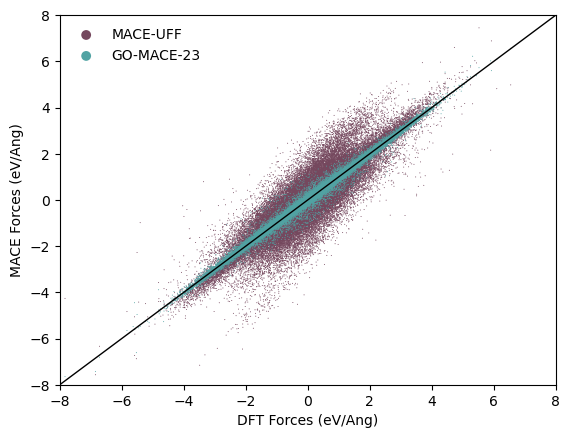

In [18]:
# parity plot
import matplotlib.pyplot as plt

plt.scatter(dft_forces, mace_uff_forces, label="MACE-UFF", s= 0.5, color="#75485E", edgecolors="none")
plt.scatter(dft_forces, mace_go_forces, label="GO-MACE-23", s=0.5, color="#51A3A3", edgecolors="none")
plt.plot([-8, 8], [-8, 8], lw=1, c="black")
plt.xlabel("DFT Forces (eV/Ang)")
plt.ylabel("MACE Forces (eV/Ang)")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
# increase markersize in legend
plt.legend(markerscale=10, frameon=False)
plt.show()

# Let's fine-tune the model! 

In [19]:
# preprocess the data by splitting the full training/testing set into smaller training/testing sets for ablation study. 
# Pick structures accoridng to config type

from sklearn.model_selection import train_test_split

train = read('training/full/train-full.xyz', index=':')
test = read('training/full/test-full.xyz', index=':')

# split the data into smaller training/testing sets
train, _ = train_test_split(train, test_size=0.95, random_state=42)
test, _ = train_test_split(test, test_size=0.95, random_state=42)

# write out new training/testing sets
write('training/10_pct/train-10.xyz', train)
write('training/10_pct/test-10.xyz', test)

In [26]:
!python /u/vld/sedm6197/miniconda3/envs/mace_uff/lib/python3.9/site-packages/mace/cli/run_train.py \
  --name="MACE" \
  --foundation_model="small" \
  --train_file="training/5_pct/train-5.xyz" \
  --valid_fraction=0.05 \
  --test_file="training/5_pct/test-5.xyz" \
  --energy_weight=1.0 \
  --forces_weight=1.0 \
  --E0s="average" \
  --loss='huber' \
  --lr=0.01 \
  --scaling="rms_forces_scaling" \
  --batch_size=30 \
  --max_num_epochs=20 \
  --swa \
  --default_dtype='float32' \
  --energy_key='QM_energy' \
  --forces_key='QM_forces' \
  --stress_weight=0 \
  --stress_key=None \
  --start_swa=10 \
  --swa_energy_weight=1000 \
  --swa_forces_weight=100 \
  --lr=0.001 \
  --ema \
  --ema_decay=0.99 \
  --amsgrad \
  --restart_latest \
  --device=cuda \
  --seed=123

2024-02-23 14:05:15.694 INFO: MACE version: 0.3.4
2024-02-23 14:05:15.694 INFO: Configuration: Namespace(name='MACE', seed=123, log_dir='logs', model_dir='.', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='downloads', device='cuda', default_dtype='float32', log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=5.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform=False, interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=3, correlation=3, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=None, max_L=None, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='training/5_pct/train-5.xyz', valid_file=None, valid_fraction=0.05, test_file='training/5_pct/test-5.xyz', E0s='average', e

# Time to check out the fine-tuned model

In [35]:
from mace.calculators import MACECalculator

calculator = MACECalculator(
    model_paths="training/10_pct/MACE_swa.model",
    device="cuda",
    default_dtype="float32"
)

In [36]:
mace_10pct_forces = get_forces(calculator, atoms)

/tmp/ipykernel_3318369/1775075830.py:4: DeprecationWarning: Please use atoms.calc = calc
  structure.set_calculator(calculator)


In [37]:
rmse_mace_ft = np.sqrt(mean_squared_error(dft_forces.flatten(), mace_10pct_forces.flatten()))
r2_mace_ft = r2_score(dft_forces.flatten(), mace_10pct_forces.flatten())

print(f"RMSE MACE UFF: {rmse_mace_uff}")
print(f"R2 MACE UFF: {r2_mace_uff}")

print(f"RMSE MACE UFF FT: {rmse_mace_ft}")
print(f"R2 MACE UFF FT: {r2_mace_ft}")

print(f"RMSE MACE GO: {rmse_mace_go}")
print(f"R2 MACE GO: {r2_mace_go}")

RMSE MACE UFF: 0.6902521443317258
R2 MACE UFF: 0.6999819894758594
RMSE MACE UFF FT: 0.20248444670582255
R2 MACE UFF FT: 0.9741824434345988
RMSE MACE GO: 0.12035932023595121
R2 MACE GO: 0.9908779751625056


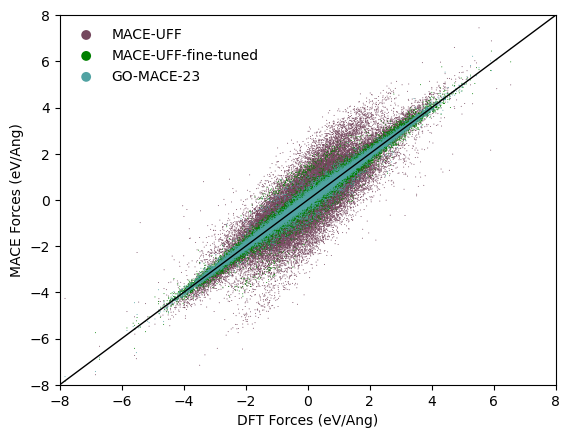

In [38]:
plt.scatter(dft_forces, mace_uff_forces, label="MACE-UFF", s= 0.5, color="#75485E", edgecolors="none")
plt.scatter(dft_forces, mace_10pct_forces, label="MACE-UFF-fine-tuned", s=0.5, color="green", edgecolors="none")
plt.scatter(dft_forces, mace_go_forces, label="GO-MACE-23", s=0.5, color="#51A3A3", edgecolors="none")
plt.plot([-8, 8], [-8, 8], lw=1, c="black")
plt.xlabel("DFT Forces (eV/Ang)")
plt.ylabel("MACE Forces (eV/Ang)")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
# increase markersize in legend
plt.legend(markerscale=10, frameon=False)
plt.show()

We see a lot of improvement using just 10 % of the data. Using this information think about some applications to your own systems and play around with fitting parameters to try and get a better fit. 